# COMP 576 Fall Final Project
# Zixuan Wang, Jiayi Du, Shicong Wang

# Pneumonia Diagnosis With Machine Learning

In [132]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Import data

Train set:
PNEUMONIA=3875
NORMAL=1341
Test set:
PNEUMONIA=390
NORMAL=234
Validation set:
PNEUMONIA=8
NORMAL=8


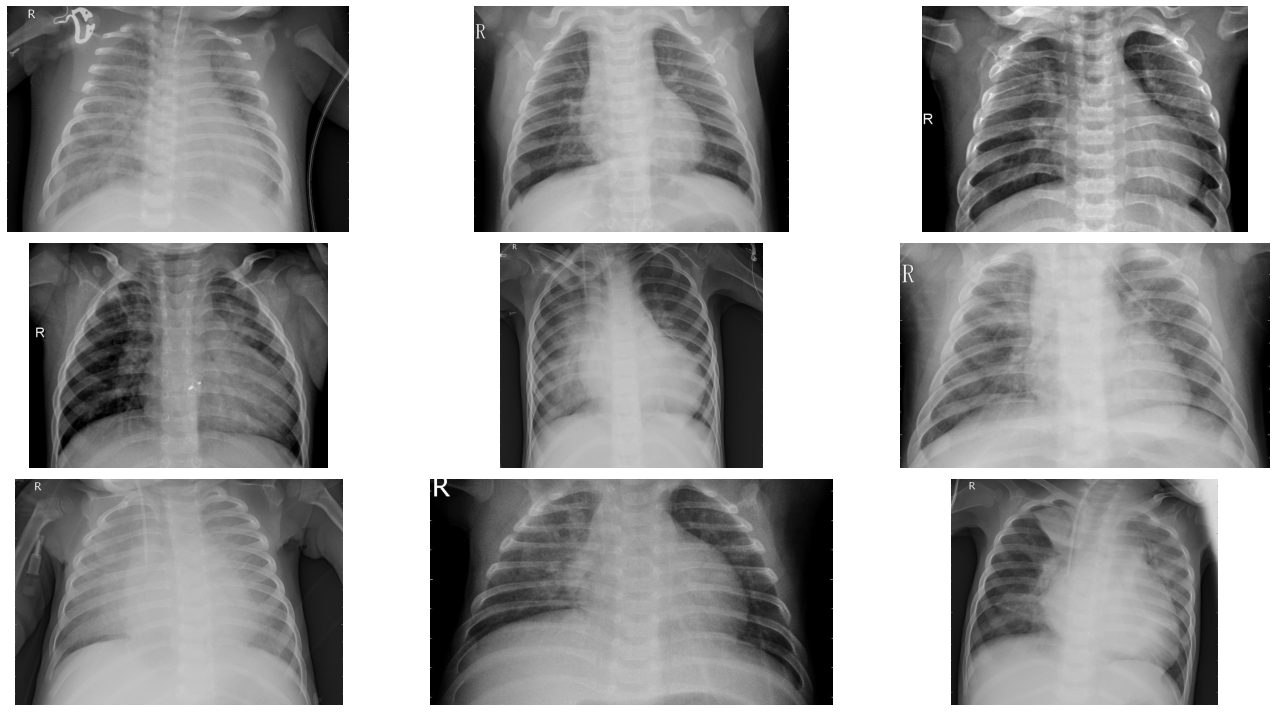

In [133]:
train_dir = "./data/train"
test_dir = "./data/test"
val_dir = "./data/val"

print("Train set:\n========================================")
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"PNEUMONIA={num_pneumonia}")
print(f"NORMAL={num_normal}")

print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))}")

print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))}")
print(f"NORMAL={len(os.listdir(os.path.join(val_dir, 'NORMAL')))}")

pneumonia = os.listdir("./data/train/PNEUMONIA")
pneumonia_dir = "./data/train/PNEUMONIA"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
plt.tight_layout()

(1858, 2090)


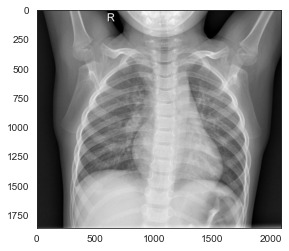

In [134]:
normal = os.listdir("./data/train/NORMAL")
normal_dir = "./data/train/NORMAL"

sample_image =plt.imread(os.path.join(normal_dir, normal[0]))
plt.imshow(sample_image,cmap='gray')
print(sample_image.shape)

# Preprcessing data

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Text(0.5, 1.0, 'Raw Chest X Ray Image')

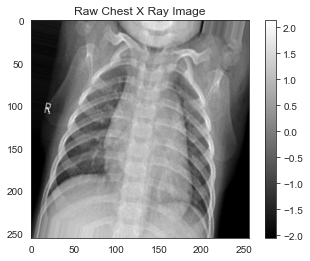

In [135]:
from keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            color_mode='grayscale',
                                            class_mode='binary',
                                            target_size=(256, 256))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                color_mode='grayscale',
                                                class_mode='binary',
                                                target_size=(256, 256))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            color_mode='grayscale',
                                            class_mode='binary',
                                            target_size=(256, 256))
                                        
sns.set_style('white')
generated_image, label = train.__getitem__(0)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')



# CNN

In [136]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(256, 256, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(256, 256, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 254, 254, 32)      320       
                                                                 
 batch_normalization_66 (Bat  (None, 254, 254, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_67 (Conv2D)          (None, 252, 252, 32)      9248      
                                                                 
 batch_normalization_67 (Bat  (None, 252, 252, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 126, 126, 32)     0         
 g2D)                                                            
                                                     

In [137]:
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

r = model.fit(
    train, 
    epochs=10,
    validation_data=validation, 
    class_weight=class_weight,
    steps_per_epoch=len(train),
    validation_steps=len(validation),
)

Weight for class 0: 0.74
Weight for class 1: 0.26
Epoch 1/10
652/652 [==============================] - 54s 82ms/step - loss: 0.4673 - accuracy: 0.8691 - val_loss: 7.8871 - val_accuracy: 0.5625
Epoch 2/10
652/652 [==============================] - 54s 83ms/step - loss: 0.1365 - accuracy: 0.8934 - val_loss: 1.4887 - val_accuracy: 0.6250
Epoch 3/10
219/652 [=========>....................] - ETA: 35s - loss: 0.0718 - accuracy: 0.9218

KeyboardInterrupt: 

In [ ]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 6s 10ms/step - loss: 0.7978 - accuracy: 0.8301
Test Accuracy: 83.01%
652/652 [==============================] - 55s 85ms/step - loss: 0.2152 - accuracy: 0.9266
Train Accuracy: 92.66%
